# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os

import numpy as np
import scipy.io
from models.resnet3D import ResNet
from models.unet3D import UNet
from models.skip3D import skip
import torch
import torch.optim
from PIL import Image

from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor


/home/oleksii/miniconda3/envs/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/oleksii/miniconda3/envs/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Choose figure

In [2]:
file_name  = 'data/inpainting/inpainting128.mat'

mat = scipy.io.loadmat(file_name)
img_np = mat["image"][:,:,:192]
img_np = img_np.transpose(2,0,1)
img_var = torch.from_numpy(img_np).type(dtype)
mask_np = mat["mask"]
mask_np = np.expand_dims(mask_np,2)
mask_np = mask_np.transpose(2,0,1)
mask_var = torch.from_numpy(mask_np).type(dtype)

# ensure all dimensions are divisible by 32 (or 2^depth)!

### Visualize

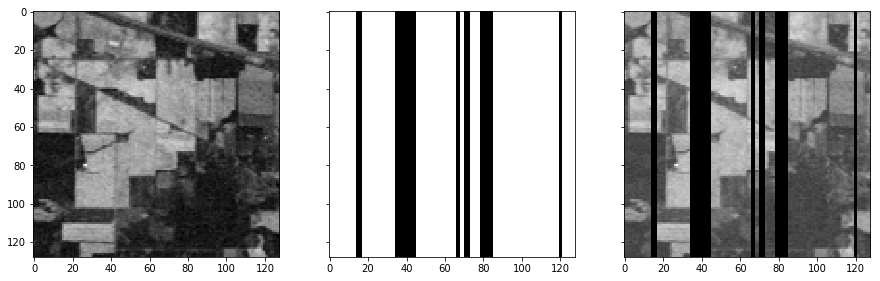

In [3]:
# band to visualize
band = 150

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
ax1.imshow(img_var[band,:,:], cmap='gray')
ax2.imshow(mask_var.permute(1,2,0).squeeze(), cmap='gray') 
ax3.imshow((img_var*mask_var)[band,:,:], cmap='gray')
plt.show()

# Setup

In [4]:
pad = 'reflection'
OPT_OVER = 'net'
OPTIMIZER = 'adam' #'LBFGS'

    
NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet
    
method = '3D'
input_depth = img_np.shape[0] 

num_iter = 10001 
reg_noise_std = 0.0 # 0.01 0.03 0.05 0.08
param_noise = True

show_every = 1000
save_every = 2000

if 'skip' in NET_TYPE:

    depth = int(NET_TYPE[-1])
    net = skip(1, 1, 
           num_channels_down = [16, 32, 64, 128, 128, 128][:depth],
           num_channels_up =   [16, 32, 64, 128, 128, 128][:depth],
           num_channels_skip =    [0, 0, 0, 0, 0, 0][:depth],  
           filter_size_up = 3,filter_size_down = 3,  filter_skip_size=1,
           upsample_mode='nearest', # downsample_mode='avg',
           need1x1_up=False,
           need_sigmoid=False, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
    '''
    # better accuracy but higher memory consumption
    net = skip(1, 1, 
               num_channels_down = [128] * 5, 
               num_channels_up =   [128] * 5,
               num_channels_skip =    [128] * 5,  
               filter_size_up = 3, filter_size_down = 3, 
               upsample_mode='nearest', filter_skip_size=1, need1x1_up=False,
               need_sigmoid=False, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    '''
    LR = 0.01 

elif NET_TYPE == 'UNET':

    net = UNet(1, 1, 
               feature_scale=8, more_layers=0, 
               concat_x=True, upsample_mode='deconv', 
               pad=pad, norm_layer=torch.nn.InstanceNorm3d, need_sigmoid=False, need_bias=True)

    LR = 0.0001 
    param_noise = False

elif NET_TYPE == 'ResNet':

    net = ResNet(1, 1, 8, 1, need_sigmoid=False, act_fun='LeakyReLU')

    LR = 0.1
    param_noise = False

else:
    assert False

net = net.type(dtype)
net_input = get_noise(input_depth, method, img_np.shape[1:]).type(dtype)

In [5]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)
img_var = img_var[None, None, :].cuda()
mask_var = mask_var[None, None, :].cuda()

Number of params: 4270833


# Main loop

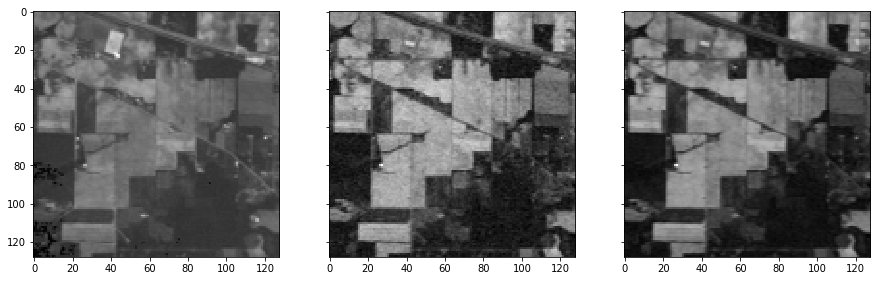

Starting optimization with ADAM


/home/oleksii/miniconda3/envs/venv/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


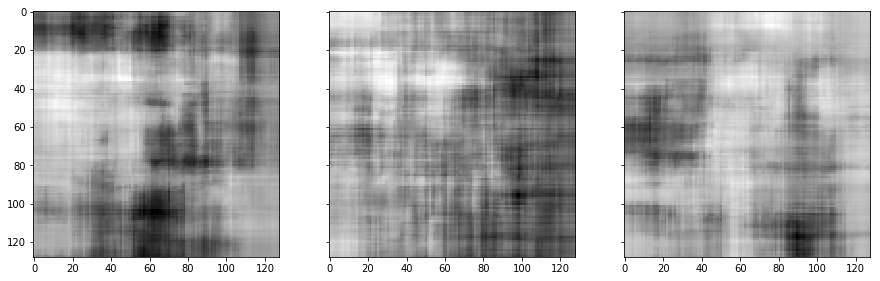

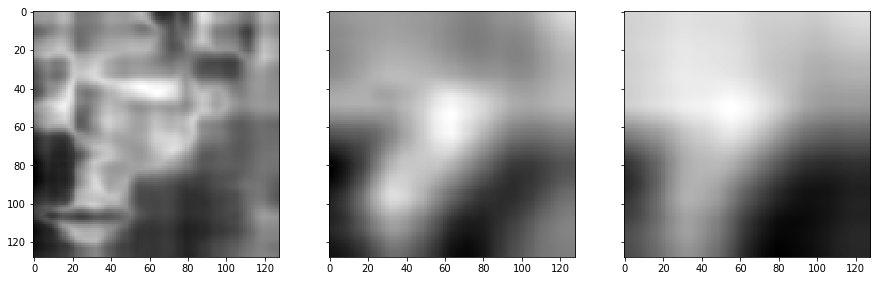

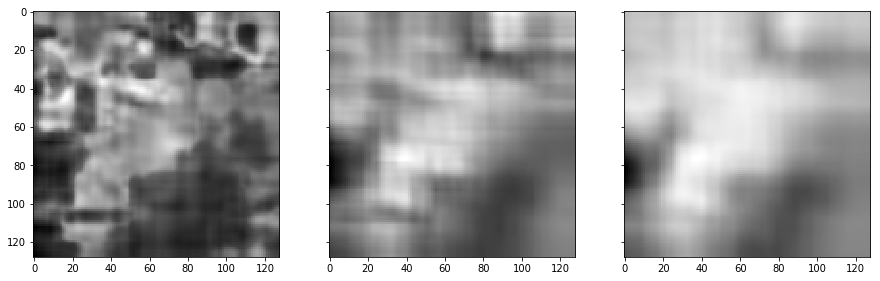

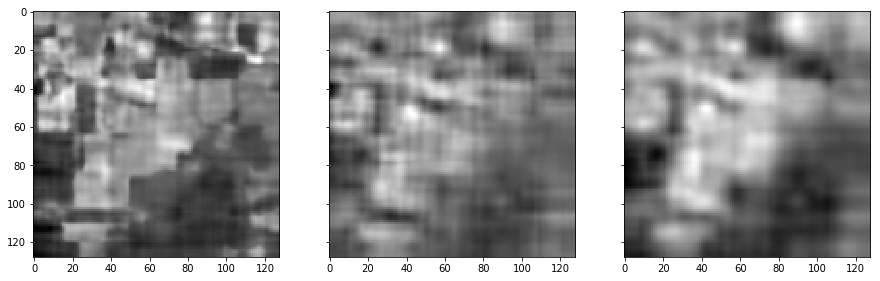

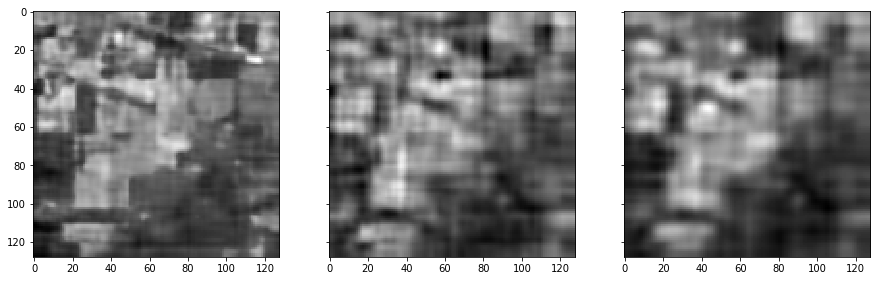

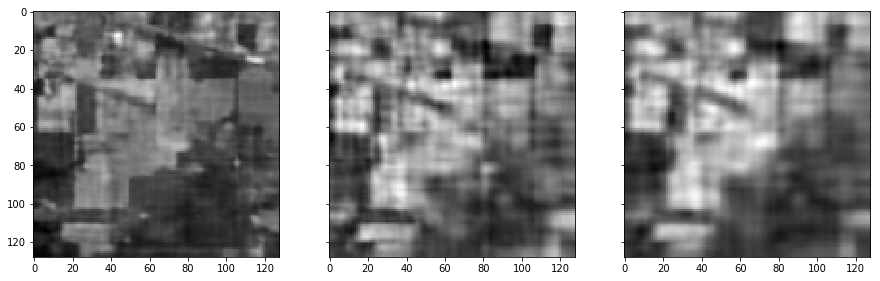

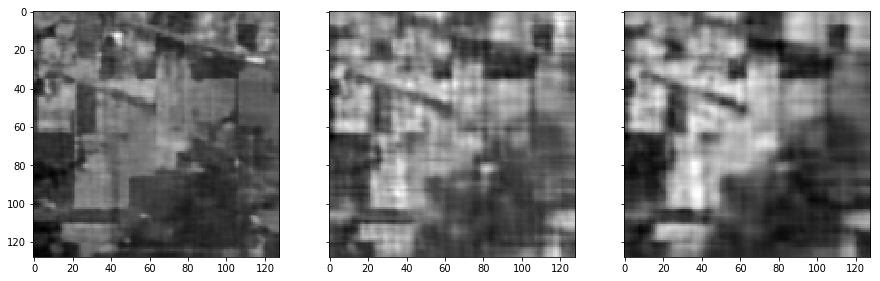

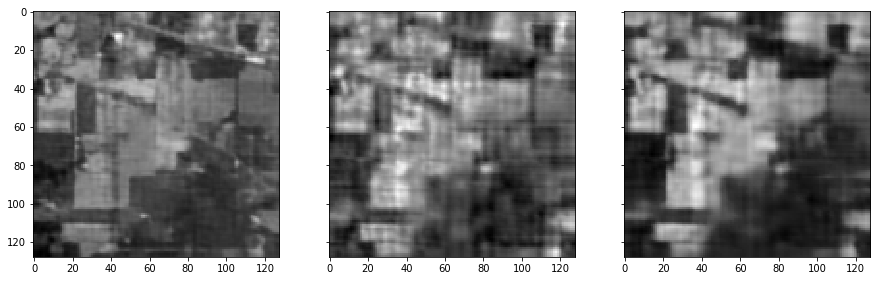

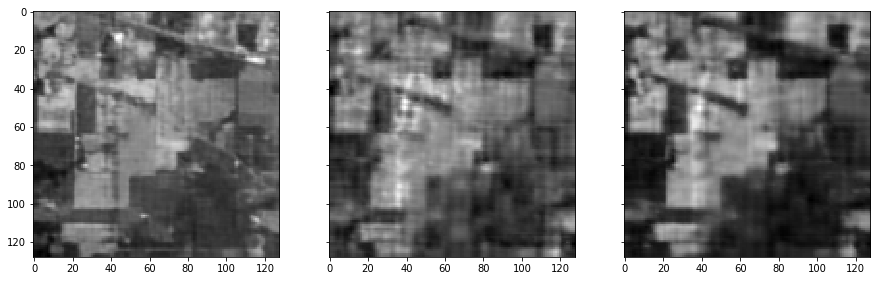

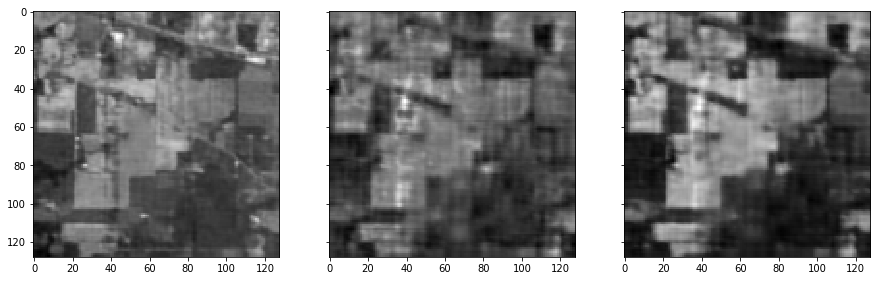

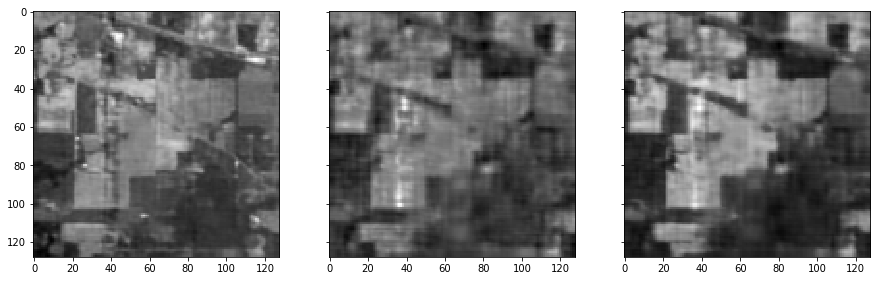

In [6]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
ax1.imshow(img_var.detach().cpu().squeeze().numpy()[10,:,:], cmap='gray')
ax2.imshow(img_var.detach().cpu().squeeze().numpy()[150,:,:], cmap='gray')
ax3.imshow(img_var.detach().cpu().squeeze().numpy()[180,:,:], cmap='gray')
plt.show()
        
i = 0
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
         
    out = net(net_input)
    
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if i % show_every == 0:
        out_np = out.detach().cpu().squeeze().numpy()
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
        ax1.imshow(out_np[10,:,:], cmap='gray')
        ax2.imshow(out_np[150,:,:], cmap='gray')
        ax3.imshow(out_np[180,:,:], cmap='gray')
        plt.show()
        
    if i % save_every == 0:
        out_np = out.detach().cpu().squeeze().numpy()
        scipy.io.savemat("results/result_inpainting_3D_it%05d_128.mat" % (i), {'pred':out_np.transpose(1,2,0)})
        
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)